During the 2018 RDKit Google Summer of Code (GSoC) project to port [MolVS](https://github.com/mcs07/MolVS) to C++, doing the tautomer enumeration and canonicalization were stretch goals. Susan actually managed to complete the tautomer enumeration, but since canonicalization wasn't complete, we didn't publicize this particularly widely. As part of the work for the 2020.03 release, I implemented Matt's canonicalization scheme and we recently merged that into the RDKit core. Since this is a topic that may be contentious, and since making changes to the canonicalization algorithm post-release will have be done very deliberately, I'd like to collect some feedback before we do the release in a couple of months.

The implementation attempts to exactly duplicate what is currently being done in MolVS. Here's how Matt describes the process in the [MolVS documentation](https://molvs.readthedocs.io/en/latest/guide/tautomer.html#tautomer-canonicalization):

1. Enumerate all possible tautomers using transform rules.
2. Use scoring system to determine canonical tautomer.
3. Canonical tautomer should be “reasonable” from a chemist’s point of view, but isn’t guaranteed to be the most energetically favourable.

The scoring scheme:
- aromatic ring (defined by all bonds being aromatic) consisting entirely of carbons: 250 points 
- other aromatic rings : 100 points
- a set of substructures are scored (if present). Here's the current (as of this writing) set of substructures and their associated scores (these are defined [here](https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/MolStandardize/Tautomer.cpp#L116)):
```
      {"benzoquinone", "[#6]1([#6]=[#6][#6]([#6]=[#6]1)=,:[N,S,O])=,:[N,S,O]", 25},
      {"oxim", "[#6]=[N][OH]", 4},
      {"C=O", "[#6]=,:[#8]", 2},
      {"N=O", "[#7]=,:[#8]", 2},
      {"P=O", "[#15]=,:[#8]", 2},
      {"C=hetero", "[#6]=[!#1;!#6]", 1},
      {"methyl", "[CX4H3]", 1},
      {"guanidine terminal=N", "[#7][#6](=[NR0])[#7H0]", 1},
      {"guanidine endocyclic=N", "[#7;R][#6;R]([N])=[#7;R]", 2},
      {"aci-nitro", "[#6]=[N+]([O-])[OH]", -4}};
```

- one point is subtracted for each H attached to P, S, Se, or Te

The highest scoring tautomer is selected. In the event of ties, the tautomer with the lexicographically smaller canonical SMILES is picked.

If this is something you feel strongly about, please try the code out and see what you think. If you see behavior you really don't like, or that you think is a bug, please add a comment to the associated issue in github: https://github.com/rdkit/rdkit/issues/2908 (preferred) or reply to the thread that I will create on the rdkit-discuss mailing list.

Remember that the goal of the exercise here is not to produce the "best" tautomer, but to produce a canonical one (always the same result for molecules which are tautomerically equivalent). We hope that this is also reasonable - in that it doesn't make a chemist's eyes burn - but that's not the primary goal.

## So how can you try it out?

This is C++ code, so you need an RDKit build done from the github master. I've done conda builds and made them available for people to try.

At the moment I've only built the beta version for python 3.7 on linux and windows. If you would like to do some testing on the Mac, let me know and I can do a build there too.

Here's how to setup a conda environment to use the beta:
```
% conda create -n py37_tautomer_beta python=3.7 jupyter
% conda activate py37_tautomer_beta
% conda install -c rdkit/label/beta rdkit
```

Ok, let's look at some examples:

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit
print(rdkit.__version__)

2020.03.1dev1


RDKit WARNING: [11:00:33] Enabling RDKit 2020.03.1dev1 jupyter extensions


In [2]:
from rdkit.Chem.MolStandardize import rdMolStandardize

In [3]:
enumerator = rdMolStandardize.TautomerEnumerator()

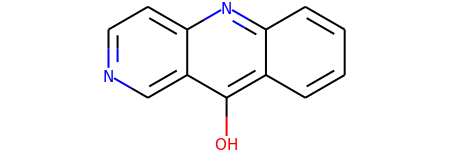

In [4]:
m = Chem.MolFromSmiles('Oc1c(cccc3)c3nc2ccncc12')
m

Get the canonical tautomer:

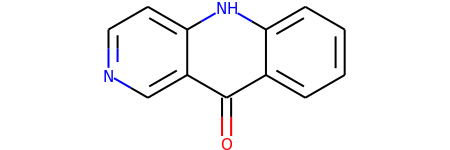

In [5]:
enumerator.Canonicalize(m)

The canonicalizer starts by enumerating a molecule's tautomers. If you want to see those, you can use the `Enumerate()` method:

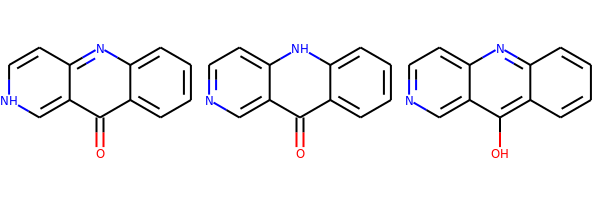

In [6]:
tauts = enumerator.Enumerate(m)
Draw.MolsToGridImage(tauts)

I find this function, which reorders the list of tautomers so that the canonical one is in the first position, really useful:

In [7]:
def reorderTautomers(m):
    enumerator = rdMolStandardize.TautomerEnumerator()
    canon = enumerator.Canonicalize(m)
    csmi = Chem.MolToSmiles(canon)
    res = [canon]
    tauts = enumerator.Enumerate(m)
    smis = [Chem.MolToSmiles(x) for x in tauts]
    stpl = sorted((x,y) for x,y in zip(smis,tauts) if x!=csmi)
    res += [y for x,y in stpl]
    return res


So now we can display all the tautomers found for a molecule. The first one drawn is the canonical one:

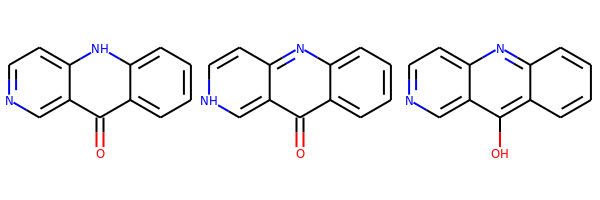

In [8]:
Draw.MolsToGridImage(reorderTautomers(m))

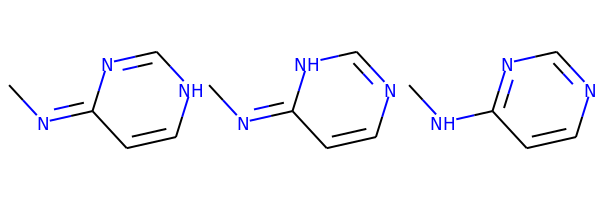

In [9]:
Draw.MolsToGridImage(reorderTautomers(Chem.MolFromSmiles('CN=c1nc[nH]cc1')))

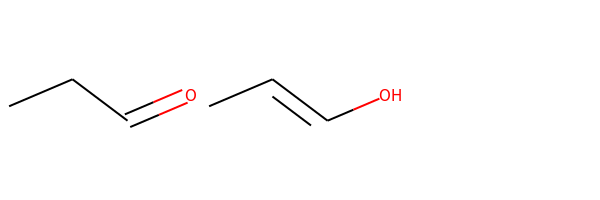

In [10]:
Draw.MolsToGridImage(reorderTautomers(Chem.MolFromSmiles('CC=CO')))

As an aside, it's worth noticing that double bond stereochemistry is removed in all tautomers if the double bond is involved in the tautomerization:

In [11]:
m = Chem.MolFromSmiles('C/C=C(/O)F')
tauts = reorderTautomers(m)
print('Original SMILES:',Chem.MolToSmiles(m))
print('Tautomers (canonical first):',[Chem.MolToSmiles(x) for x in tauts])

Original SMILES: C/C=C(/O)F
Tautomers (canonical first): ['CCC(=O)F', 'CC=C(O)F']
